## PROBLEM 4

  
 ###  I created trainMask by using ipad to highlight over regions of training image with pools. I am first going to cut the image into 10x10 blocks and then I am going to determine which blocks have some percent or more mask coloring in them. If they have that percent coloring I am going to say these are pool blocks. I am then going to flatten the blocks, and use PCA to reduce their dimensionality. I am then going to create two gaussians, one for the PCA reduced pool blocks and one for the PCA reduced background blocks. I am now going to use their discriminant functions (similar to problem 1) to determine which block is pool and which block is background

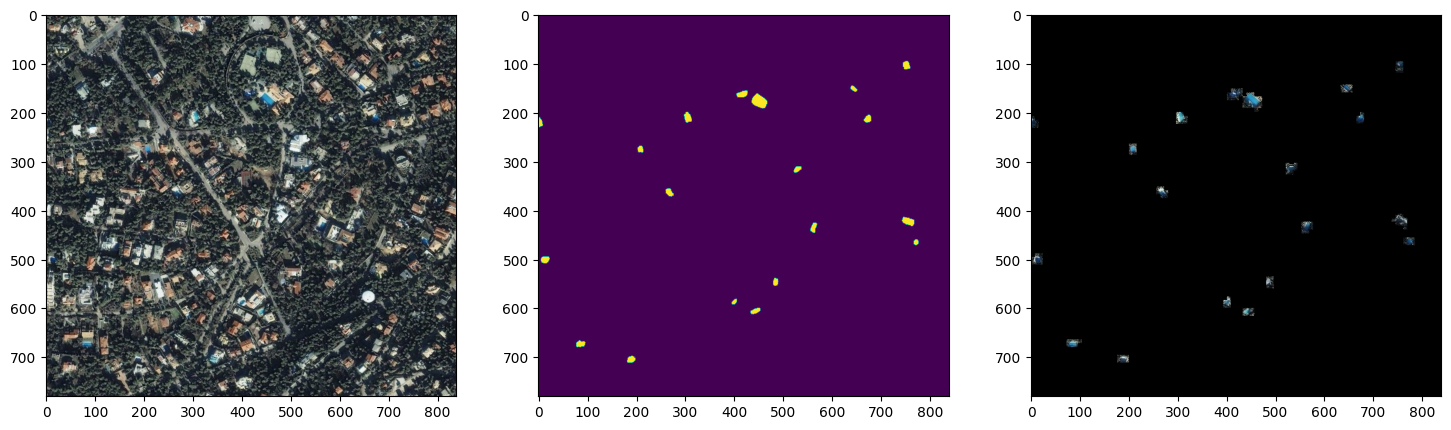

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Save image in set directory
# I FLIP THE COLORS SINCE OPENCV READS BGR
trainImg = cv2.imread('./ekalismall.png')[:, :, ::-1]
testImg = cv2.imread('./ekalismall2.png')[:, :, ::-1]
trainMask = cv2.imread("./mask.JPEG")[:, :, ::-1]
trainMask = cv2.resize(trainMask, (trainImg.shape[1], trainImg.shape[0]))
trainMask = trainMask[:,:,0]
segmented = np.copy(trainImg)
segmented[trainMask == 0] = 0  # Set pixels not in the mask to 0

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(trainImg)
axs[1].imshow(trainMask)  
axs[2].imshow(segmented)

In [102]:
# new_train_img = np.copy(trainImg)
# blue_channel_index = 2  # Blue channel is the third channel after reversing the colors

# trainImg_filtered = np.copy(trainImg)

# # blue_channel = trainImg_filtered[:, :, blue_channel_index]
# # blue_channel = cv2.erode(blue_channel, np.ones((1, 2)), iterations=1)

# # trainImg_filtered[:, :, blue_channel_index] = blue_channel

# max_color_indices = np.argmax(trainImg_filtered, axis=2)

# for i in range(trainImg_filtered.shape[0]):
#     for j in range(trainImg_filtered.shape[1]):
#         if max_color_indices[i, j] != blue_channel_index:
#             new_train_img[i, j] = [0, 0, 0]  # Set pixel to black

# plt.figure(figsize=(6, 6))
# plt.imshow(new_train_img)
# plt.show()

I "labeled" image on my ipad by highlihting regions with pools. I am first going to cut the image into 24x24 blocks and then I am going to use determine which blocks have atleast a coloring in them. If they do I am going to use say these are pool blocks.

In [103]:
from skimage.util.shape import view_as_blocks

block_size = (10, 10, 3)

rows, cols, _ = trainImg.shape
trimmed_rows = rows - (rows % block_size[0])
trimmed_cols = cols - (cols % block_size[1])
trimmed_trainImg = trainImg[:trimmed_rows, :trimmed_cols, :]
print(trimmed_trainImg.shape, trainImg.shape)
# Split the trimmed trainImg into blocks
blocks = view_as_blocks(trimmed_trainImg, block_size)
print(blocks.shape)


# blocks = blocks.reshape(blocks.shape[0], blocks.shape[1], -1, block_size[0], block_size[1], 3)
# blocks = np.moveaxis(blocks, 2, 1)
# blocks = blocks.reshape(-1, block_size[0], block_size[1], 3)
# print(blocks.shape)

# fig, axs = plt.subplots(1, 5, figsize=(18, 6))
# for i in range(5):
#     axs[i].imshow(blocks[i])
#     axs[i].axis('off')

plt.show()

(780, 830, 3) (780, 839, 3)
(78, 83, 1, 10, 10, 3)


(780, 830)


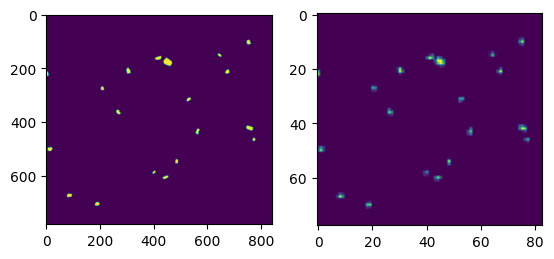

In [104]:
blockMask = trainMask[:trimmed_rows, :trimmed_cols]

import numpy as np
print(blockMask.shape)
H, W = blockMask.shape
block_size = (10, 10)

blockMask = view_as_blocks(blockMask, block_size)
blockMaskSummed = np.sum(blockMask, axis=(2, 3))

fig,axs = plt.subplots(1,2)
axs[0].imshow(trainMask)
axs[1].imshow(blockMaskSummed)


### I said that atleast 48 of the 100 pixels in the block musk be pool (based on mask I drew above) if we are to call the block a pool block

60.0


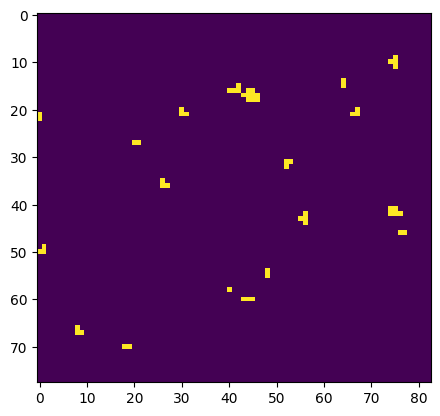

In [105]:

blockLabels = np.zeros(blockMask.shape[:2])
for i in range(blockMask.shape[0]):
    for j in range(blockMask.shape[1]):
        temp = blockMask[i,j]
        if(np.sum(temp)//255 >= 20): 
            blockLabels[i,j]  = 1

print(np.sum(blockLabels))
plt.imshow(blockLabels)

In [106]:
# def decisionWeights(m,c, prior = 1/2): # assumes prior = 1/2 as you are doing this with 2
#     cinv = np.linalg.inv(c)
#     w1 = -1/2*cinv
#     w2 = cinv @ m.reshape(-1,1)
#     w3 = -1/2* m @ cinv @ m.reshape(-1,1) +  -1/2 *np.log(np.linalg.det(c)) + np.log(prior)
#     return (w1,w2,w3)

# def evaluateDecision(x,weightsList): #weightsList is a a list of tuples (w1,w2,w3)
#     #returns index of weight set that is greatest
#     toMax = np.zeros(len(weightsList))
#     for i in range(len(weightsList)):
#         temp = weightsList[i]
#         toMax[i] = x.reshape(1,-1) @ temp[0] @ x.reshape(-1,1) + temp[1].T @ x.reshape(-1,1)  + temp[2]

#     return np.argmax(toMax)


# def rgbvalsToMeanAndCov(vals): #takes RGB vals as columns 
#     mean = np.mean(vals, axis=1)
#     cov = 1/vals.shape[1] * ((vals - mean.reshape(-1,1)) @ (vals - mean.reshape(-1,1)).T)
#     return mean, cov

def pca(data): #takes input data as columns and expects it to be 0 mean (add mean back later if intended)
    covariance_matrix = np.dot(data,data.T)/(data.shape[1])
    eigvals, eigvecs = np.linalg.eigh(covariance_matrix)
    eigvals = eigvals[::-1]
    eigvecs = eigvecs[:,::-1]

    return (eigvecs,eigvals)

### We now have flattened 10x10x3 blocks in columns and cooresponding labels. I now PCA reduce to 30 dimensions

In [107]:
flattenedBlocks = blocks.reshape(-1,300).T
flatBlockLabels = np.ravel(blockLabels)
normalBlockMean = np.mean(flattenedBlocks,axis=1).reshape(-1,1)
eigvecs, eigvals =  pca(flattenedBlocks - normalBlockMean)
numPCA = 100
PCAmat = eigvecs.T[:numPCA]
flattenedBlocks = blocks.reshape(-1,300).T
flattenedPCA =  PCAmat @ flattenedBlocks
flatBlockLabels = np.ravel(blockLabels)
trainMean = np.mean(flattenedPCA,axis=1).reshape(-1,1)

poolMean  = np.mean(flattenedPCA[:,flatBlockLabels == 1],axis = 1).reshape(-1,1)
bkgMean = np.mean(flattenedPCA[:,flatBlockLabels == 0],axis =1).reshape(-1,1)

In [108]:
# mpool,covpool = rgbvalsToMeanAndCov(poolPCA)
# mBG,covBG = rgbvalsToMeanAndCov(backgroundPCA)

# PoolWeights = decisionWeights(mpool,covpool, prior= 1/20)
# BGWeights = decisionWeights(mBG,covBG, prior=19/20)

In [109]:
LDAtrain  = flattenedPCA.copy()
ldaLabels = flatBlockLabels.copy()


dimensionality = LDAtrain.shape[0]
from scipy.linalg import eigh

BetweenCov = np.zeros((dimensionality,dimensionality)) # since nfft +1 as we cut specotrgram and keep DC term
WithinCov = np.zeros((dimensionality,dimensionality))
print(trainMean.shape)
BetweenCov += (poolMean.reshape(-1,1) - trainMean).reshape(-1,1) @ (poolMean.reshape(-1,1) - trainMean).reshape(1,-1)
BetweenCov += (bkgMean - trainMean).reshape(-1,1) @ (bkgMean - trainMean).reshape(1,-1)

for i in range(LDAtrain.shape[1]):
    samp =  LDAtrain[:,i]
    if(ldaLabels[i] == 1):
        left = (samp.reshape(-1,1) - poolMean.reshape(-1,1))
        right = (samp.reshape(1,-1) - poolMean.reshape(1,-1))
    else:
        left = (samp.reshape(-1,1) - bkgMean.reshape(-1,1))
        right = (samp.reshape(1,-1) - bkgMean.reshape(1,-1))
    WithinCov += left@ right

geneigvals, geneigvecs = eigh(BetweenCov, WithinCov, eigvals_only=False)

geneigvals = geneigvals[::-1]
geneigvecs =  geneigvecs[:,::-1]

geneigvecs = geneigvecs.T



(100, 1)


In [110]:
LDAmat = geneigvecs @ PCAmat

In [111]:
# PthenBGweights = [PoolWeights,BGWeights]
# output = np.zeros(blocks.shape[:2])
# for i in range(blocks.shape[0]):
#     for j in range(blocks.shape[1]):
#         output[i,j] = evaluateDecision(x= PCAmat@ (blocks[i,j].reshape(300,1)- trainMean),weightsList= PthenBGweights)

In [127]:
output = np.zeros(blocks.shape[:2])
for i in range(blocks.shape[0]):
    for j in range(blocks.shape[1]):
        output[i,j] = LDAmat[0]@ (blocks[i,j].reshape(300,1)- normalBlockMean) > 0.075

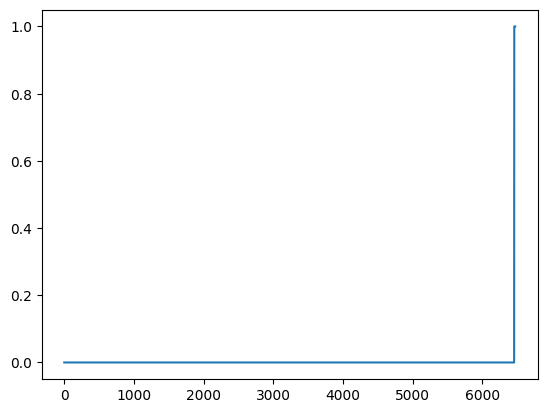

In [128]:
plt.plot(np.sort(output.ravel()))

### Training Output

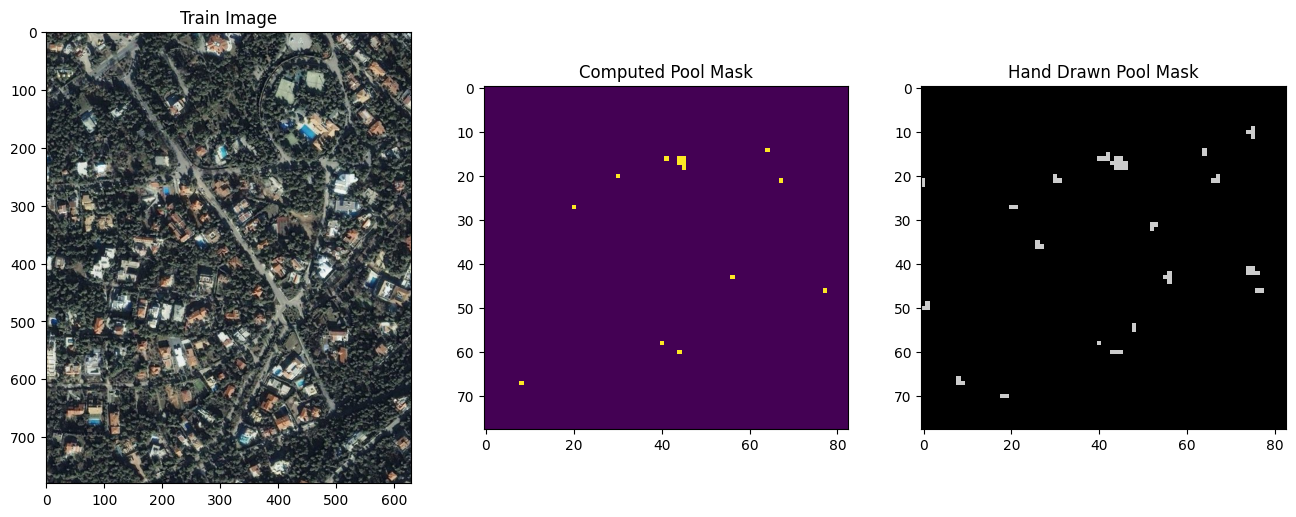

In [129]:
fig, axs = plt.subplots(1, 3, figsize=(16, 12))

axs[0].imshow(trainImg[:trimmed_rows, :trimmed_cols, :])
axs[0].set_title('Train Image')

axs[1].imshow(output)
axs[1].set_title('Computed Pool Mask')

axs[2].imshow(blockLabels, cmap='nipy_spectral') 
axs[2].set_title('Hand Drawn Pool Mask')

plt.show()

### Getting testing output

In [130]:
block_size = (10, 10, 3)

rows, cols, _ = testImg.shape
trimmed_rows = rows - (rows % block_size[0])
trimmed_cols = cols - (cols % block_size[1])
trimmed_testImg = testImg[:trimmed_rows, :trimmed_cols, :]
print(trimmed_testImg.shape, testImg.shape)
testBlocks = view_as_blocks(trimmed_testImg, block_size)
print(blocks.shape)

flatTestBlocks = blocks.reshape(300,-1)

pcaTestData = PCAmat @ (flatTestBlocks - trainMean)

(860, 630, 3) (867, 635, 3)
(78, 83, 1, 10, 10, 3)


ValueError: operands could not be broadcast together with shapes (300,6474) (100,1) 

In [ ]:
outputTest = np.zeros(testBlocks.shape[:2])
for i in range(testBlocks.shape[0]):
    for j in range(testBlocks.shape[1]):
        outputTest[i,j] = evaluateDecision(x= PCAmat@ testBlocks[i,j].reshape(300,1),weightsList= PthenBGweights)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


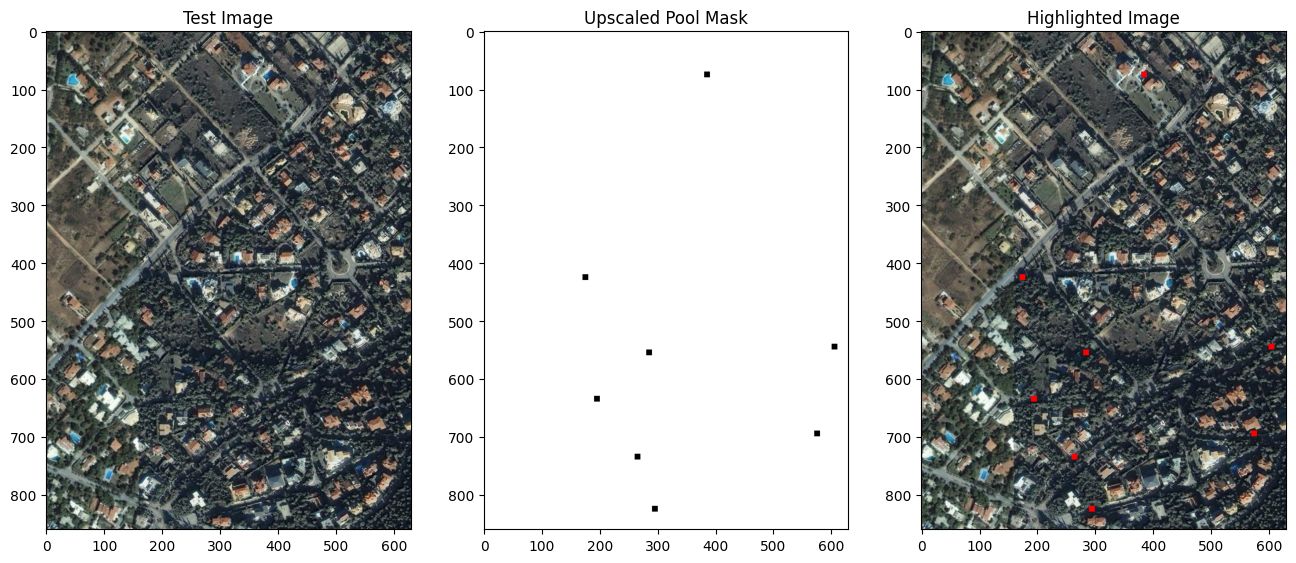

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Upscale the Pool Mask by a factor of 10x
upscale_factor = 10
upscaled_pool_mask = np.kron(outputTest, np.ones((upscale_factor, upscale_factor)))
print(upscaled_pool_mask)
# Apply the upscaled mask to the test image
highlighted_image = testImg.copy()[:trimmed_rows, :trimmed_cols, :]  # Create a copy of the test image
highlighted_image[upscaled_pool_mask == 0] = [255, 0, 0]  # Set pixels to red where mask is 1

# Create subplots to display the images
fig, axs = plt.subplots(1, 3, figsize=(16, 12))

axs[0].imshow(testImg[:trimmed_rows, :trimmed_cols, :])
axs[0].set_title('Test Image')

axs[1].imshow(upscaled_pool_mask, cmap='gray')
axs[1].set_title('Upscaled Pool Mask')

axs[2].imshow(highlighted_image[:trimmed_rows, :trimmed_cols, :])
axs[2].set_title('Highlighted Image')

plt.show()